In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [18]:
file_path = 'Nmetil.csv'

# Citește datele cu headerul corect și separare pe spații multiple
data = pd.read_csv(file_path, 
                   sep=r'\s+',   # separă după spații multiple
                   header=0,     # prima linie e header
                   engine='python')

# Curăță numele coloanelor: elimină parantezele și spațiile
data.columns = [col.replace(' ', '').replace('(', '').replace(')', '') for col in data.columns]

print("Datele au fost încărcate corect!")
print("\nColoane:", data.columns.tolist())
print("\nPrimele 5 rânduri:\n", data.head())


Datele au fost încărcate corect!

Coloane: ['Step', 'TK', 'E_KSeV', 'E_toteV', 'VolA^3', 'PkBar']

Primele 5 rânduri:
    Step    TK      E_KSeV     E_toteV    VolA^3  PkBar
0     1  0.00 -1300.41332 -1300.41332  2468.205  0.510
1     2  0.01 -1300.41334 -1300.41332  2468.205  0.508
2     3  0.04 -1300.41340 -1300.41332  2468.205  0.502
3     4  0.08 -1300.41350 -1300.41332  2468.205  0.495
4     5  0.14 -1300.41364 -1300.41332  2468.205  0.483


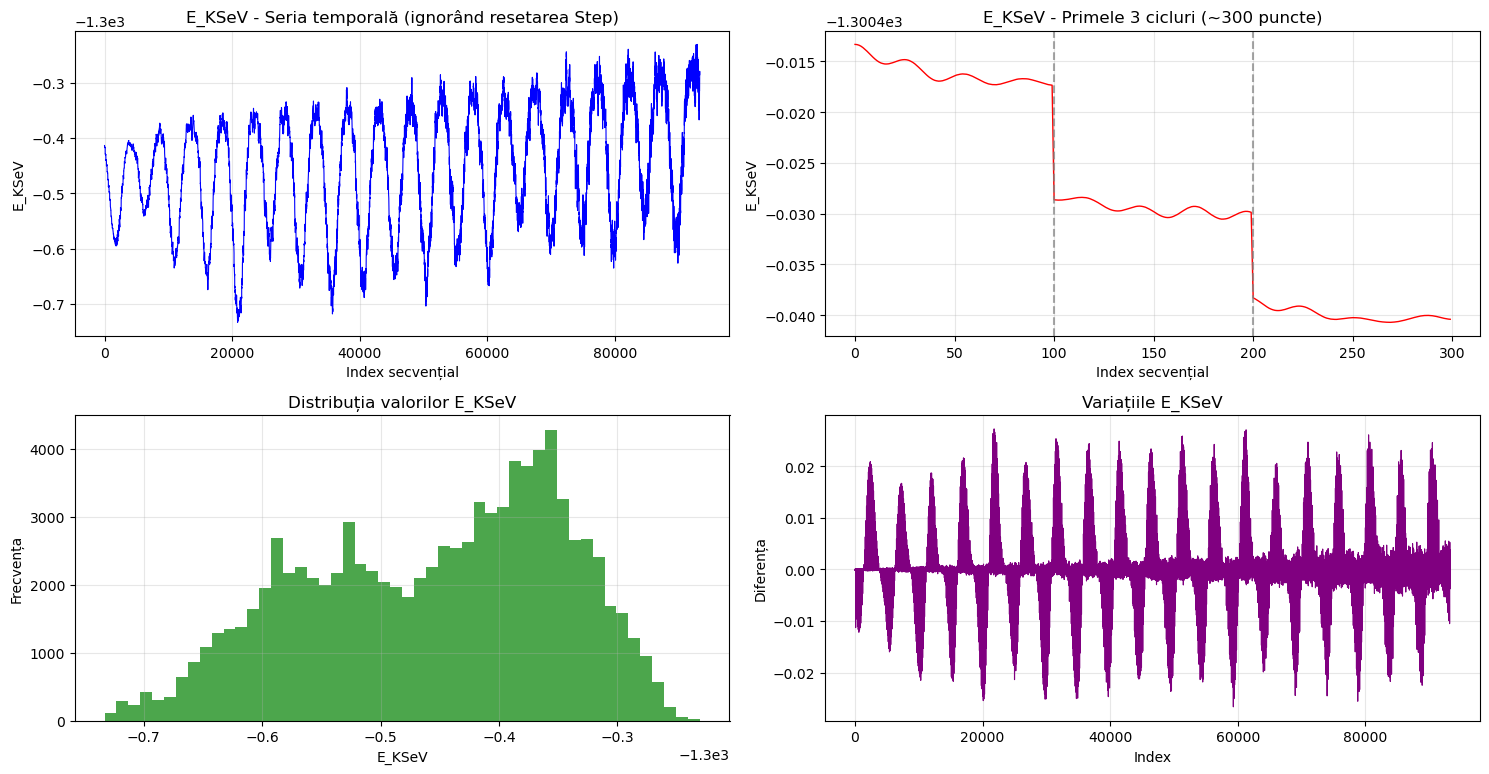


📊 Statistici E_KSeV:
Media: -1300.454578
Std Dev: 0.107881
Min: -1300.733020
Max: -1300.230460
Range: 0.502560


In [20]:
plt.figure(figsize=(15, 8))

# Seria temporală cu Step-urile reale
plt.subplot(2, 2, 1)
plt.plot(data['E_KSeV'], 'b-', linewidth=0.8)
plt.title('E_KSeV - Seria temporală (ignorând resetarea Step)')
plt.xlabel('Index secvențial')
plt.ylabel('E_KSeV')
plt.grid(True, alpha=0.3)

# Primele 3 cicluri (3 x 100 puncte aproximativ)
plt.subplot(2, 2, 2)
n_cycles = 3
n_points = n_cycles * 100
if len(data) >= n_points:
    plt.plot(data['E_KSeV'][:n_points], 'r-', linewidth=1)
    # Adaugă linii verticale la fiecare resetare (aproximativ)
    for i in range(1, n_cycles):
        plt.axvline(x=i*100, color='gray', linestyle='--', alpha=0.7)
    plt.title(f'E_KSeV - Primele {n_cycles} cicluri (~{n_points} puncte)')
else:
    plt.plot(data['E_KSeV'], 'r-', linewidth=1)
    plt.title('E_KSeV - Toate datele disponibile')
plt.xlabel('Index secvențial')
plt.ylabel('E_KSeV')
plt.grid(True, alpha=0.3)

# Distribuția valorilor
plt.subplot(2, 2, 3)
plt.hist(data['E_KSeV'], bins=50, alpha=0.7, color='green')
plt.title('Distribuția valorilor E_KSeV')
plt.xlabel('E_KSeV')
plt.ylabel('Frecvența')
plt.grid(True, alpha=0.3)

# Diferențele (variațiile)
plt.subplot(2, 2, 4)
differences = np.diff(data['E_KSeV'])
plt.plot(differences, 'purple', linewidth=0.8)
plt.title('Variațiile E_KSeV')
plt.xlabel('Index')
plt.ylabel('Diferența')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistici
print(f"\n📊 Statistici E_KSeV:")
print(f"Media: {data['E_KSeV'].mean():.6f}")
print(f"Std Dev: {data['E_KSeV'].std():.6f}")
print(f"Min: {data['E_KSeV'].min():.6f}")
print(f"Max: {data['E_KSeV'].max():.6f}")
print(f"Range: {data['E_KSeV'].max() - data['E_KSeV'].min():.6f}")


In [23]:

def create_sequences(data, window_size, pred_size=1):
    """Creează secvențe pentru LSTM"""
    X, y = [], []
    for i in range(len(data) - window_size - pred_size + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size:(i + window_size + pred_size)])
    return np.array(X), np.array(y)

# Extragerea seriei E_KSeV
energy_values = data['E_KSeV'].values.reshape(-1, 1)

# Normalizarea (foarte importantă pentru variații mici)
scaler = MinMaxScaler(feature_range=(-1, 1))
energy_scaled = scaler.fit_transform(energy_values)

# Parametri
WINDOW_SIZE = 100     # Un ciclu complet (Step se resetează la 100)
PRED_SIZE = 10        # Câte puncte prezicem
TRAIN_RATIO = 0.8     # 80% pentru antrenare

print(f"\n🔧 Pregătirea datelor pentru cicluri de 100:")
print(f"Valori originale - Range: [{energy_values.min():.6f}, {energy_values.max():.6f}]")
print(f"Valori normalizate - Range: [{energy_scaled.min():.6f}, {energy_scaled.max():.6f}]")
print(f"WINDOW_SIZE = {WINDOW_SIZE} (un ciclu complet)")
print(f"Numărul de cicluri complete în date: ~{len(data)//100}")


# Crearea secvențelor
X, y = create_sequences(energy_scaled.flatten(), WINDOW_SIZE, PRED_SIZE)
print(f"Secvențe create - X: {X.shape}, y: {y.shape}")

# Împărțirea train/test
split_idx = int(len(X) * TRAIN_RATIO)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape pentru LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Train: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test: X_test {X_test.shape}, y_test {y_test.shape}")


🔧 Pregătirea datelor pentru cicluri de 100:
Valori originale - Range: [-1300.733020, -1300.230460]
Valori normalizate - Range: [-1.000000, 1.000000]
WINDOW_SIZE = 100 (un ciclu complet)
Numărul de cicluri complete în date: ~933
Secvențe create - X: (93191, 100), y: (93191, 10)
Train: X_train (74552, 100, 1), y_train (74552, 10)
Test: X_test (18639, 100, 1), y_test (18639, 10)


In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(WINDOW_SIZE, 1)),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    Dense(25),
    Dense(PRED_SIZE) # Output layer matches PRED_SIZE
])

W0000 00:00:1754298692.970901    7094 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [26]:
# Compilarea
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='mse', 
              metrics=['mae'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,135 (125.53 KB)

 Trainable params: 32,135 (125.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=15, min_lr=1e-7
)

In [30]:
# Antrenarea
print(f"\n Incepe suferinta")
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Antrenarea completa!")


 Incepe suferinta
Epoch 1/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 110s 59ms/step - loss: 0.0016 - mae: 0.0291 - val_loss: 9.7603e-04 - val_mae: 0.0238 - learning_rate: 0.0010
Epoch 2/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - loss: 0.0016 - mae: 0.0288 - val_loss: 8.7885e-04 - val_mae: 0.0214 - learning_rate: 0.0010
Epoch 3/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 47s 25ms/step - loss: 0.0016 - mae: 0.0288 - val_loss: 0.0012 - val_mae: 0.0276 - learning_rate: 0.0010
Epoch 4/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 115s 62ms/step - loss: 0.0015 - mae: 0.0284 - val_loss: 8.8379e-04 - val_mae: 0.0222 - learning_rate: 0.0010
Epoch 5/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 109s 58ms/step - loss: 0.0015 - mae: 0.0283 - val_loss: 7.9750e-04 - val_mae: 0.0199 - learning_rate: 0.0010
Epoch 6/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 110s 59ms/step - loss: 0.0015 - mae: 0.0286 - val_loss: 7.5420e-04 - val_mae: 0.0202 - learning_rate: 0.0010
Epoch 7/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 47s 25ms/step - loss: 0.0015 - mae: 0.0

In [32]:
# =============================================================================
# 5. EVALUAREA MODELULUI
# =============================================================================

# Predicții
y_pred = model.predict(X_test, verbose=0)

# Denormalizarea
# Ensure y_test and y_pred are reshaped correctly for inverse_transform
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, PRED_SIZE)).flatten()
y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, PRED_SIZE)).flatten()


# Metrici
mse = mean_squared_error(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)

print(f"\n📈 Performanța modelului:")
print(f"MSE: {mse:.8f}")
print(f"MAE: {mae:.8f}")
print(f"RMSE: {rmse:.8f}")

# Eroarea relativă
# Avoid division by zero for relative error calculation
relative_error = np.abs((y_test_orig - y_pred_orig) / (y_test_orig + 1e-8)) * 100 # Added small epsilon
print(f"Eroarea relativă medie: {np.mean(relative_error):.4f}%")


📈 Performanța modelului:
MSE: 0.00006614
MAE: 0.00591117
RMSE: 0.00813269
Eroarea relativă medie: 0.0005%


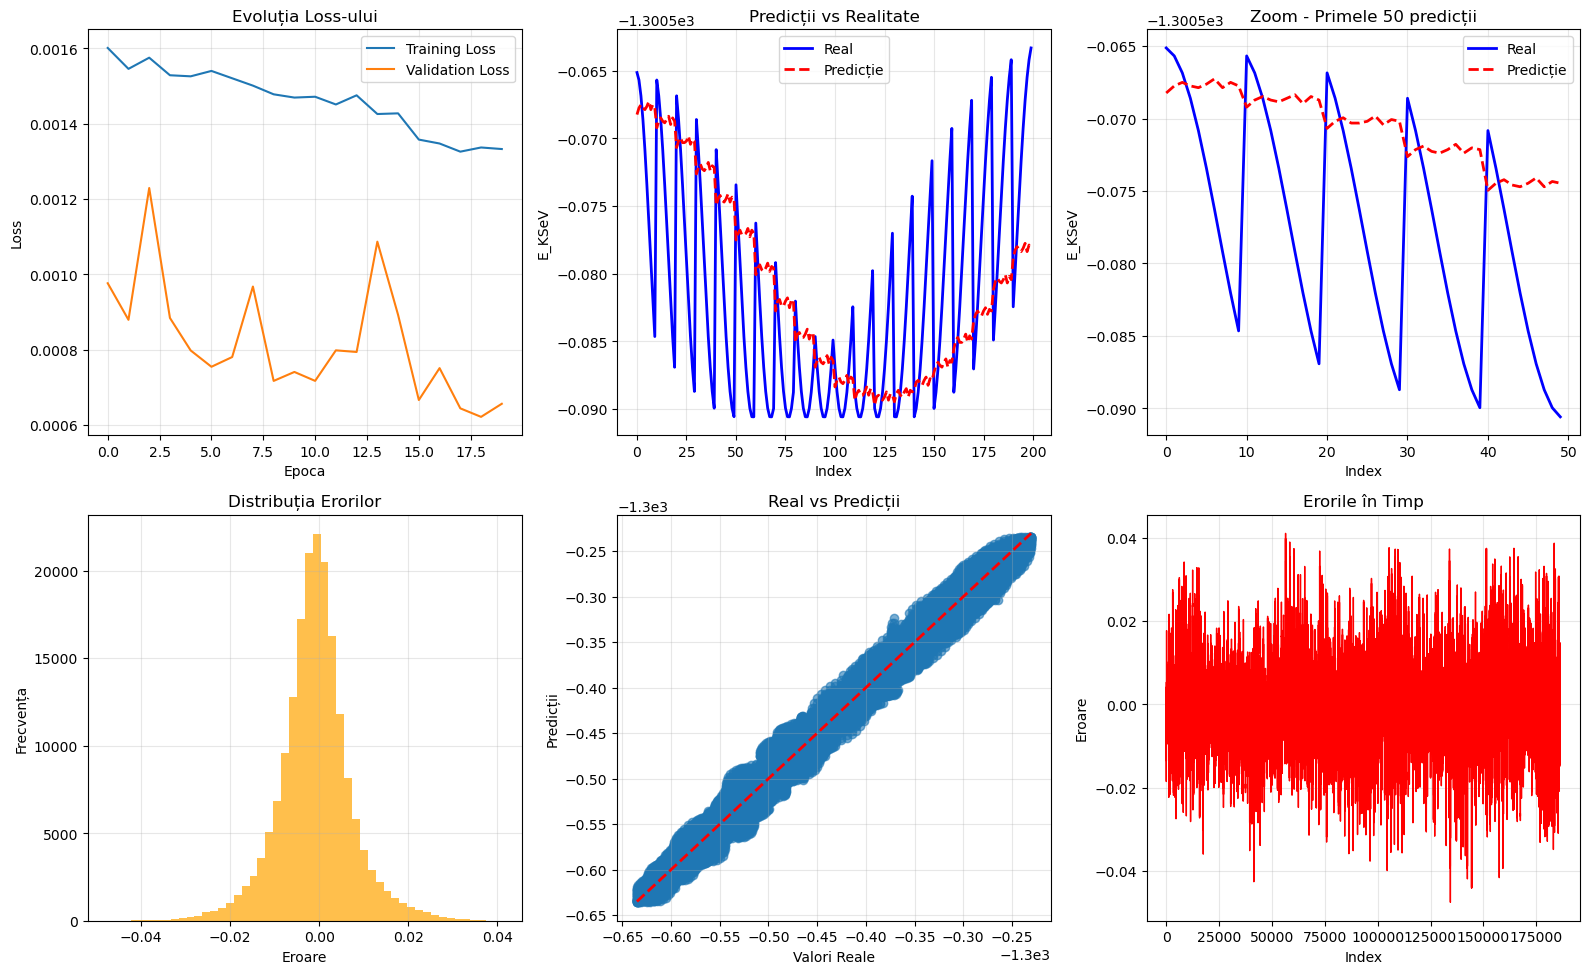

In [33]:
# =============================================================================
# 6. VIZUALIZAREA REZULTATELOR
# =============================================================================

plt.figure(figsize=(16, 10))

# Evoluția loss-ului
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evoluția Loss-ului')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Comparația predicțiilor (primele 200 puncte)
plt.subplot(2, 3, 2)
n_show = min(200, len(y_test_orig))
plt.plot(range(n_show), y_test_orig[:n_show], 'b-', label='Real', linewidth=2)
plt.plot(range(n_show), y_pred_orig[:n_show], 'r--', label='Predicție', linewidth=2)
plt.title('Predicții vs Realitate')
plt.xlabel('Index')
plt.ylabel('E_KSeV')
plt.legend()
plt.grid(True, alpha=0.3)

# Zoom pe primele 50 predicții
plt.subplot(2, 3, 3)
n_zoom = min(50, len(y_test_orig))
plt.plot(range(n_zoom), y_test_orig[:n_zoom], 'b-', label='Real', linewidth=2)
plt.plot(range(n_zoom), y_pred_orig[:n_zoom], 'r--', label='Predicție', linewidth=2)
plt.title('Zoom - Primele 50 predicții')
plt.xlabel('Index')
plt.ylabel('E_KSeV')
plt.legend()
plt.grid(True, alpha=0.3)

# Distribuția erorilor
plt.subplot(2, 3, 4)
errors = y_test_orig - y_pred_orig
plt.hist(errors, bins=50, alpha=0.7, color='orange')
plt.title('Distribuția Erorilor')
plt.xlabel('Eroare')
plt.ylabel('Frecvența')
plt.grid(True, alpha=0.3)

# Scatter plot Real vs Predicții
plt.subplot(2, 3, 5)
plt.scatter(y_test_orig, y_pred_orig, alpha=0.6)
plt.plot([y_test_orig.min(), y_test_orig.max()],
          [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.title('Real vs Predicții')
plt.xlabel('Valori Reale')
plt.ylabel('Predicții')
plt.grid(True, alpha=0.3)

# Erorile în timp
plt.subplot(2, 3, 6)
plt.plot(errors, color='red', linewidth=1)
plt.title('Erorile în Timp')
plt.xlabel('Index')
plt.ylabel('Eroare')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


🔮 Predicții pentru următorul ciclu (100 pași):
Primele 10 valori prezise pentru noul ciclu:
Step 1: -1300.287109
Step 2: -1300.287598
Step 3: -1300.287476
Step 4: -1300.287354
Step 5: -1300.287231
Step 6: -1300.287476
Step 7: -1300.287842
Step 8: -1300.287598
Step 9: -1300.288208
Step 10: -1300.287842


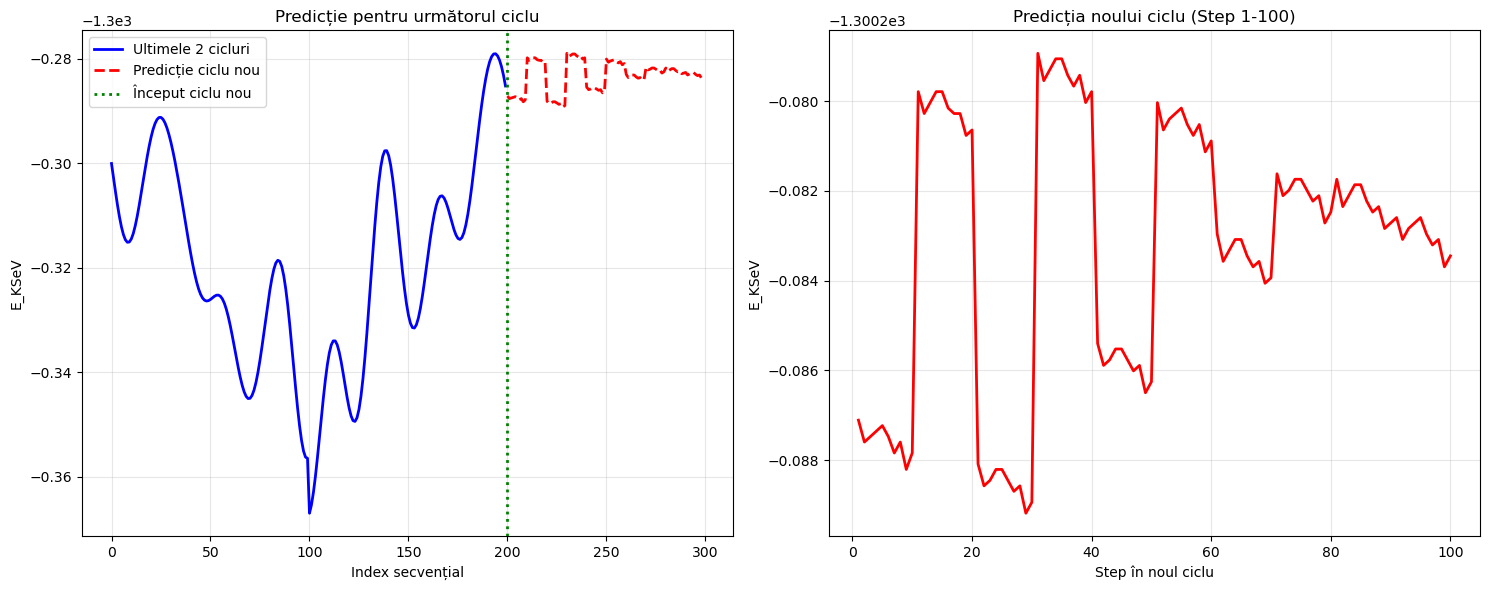


📊 Statistici predicții viitoare:
Media: -1300.283081
Std Dev: 0.002982
Min: -1300.289185
Max: -1300.278931


In [34]:
# =============================================================================
# 7. PREDICȚII PENTRU VIITOR
# =============================================================================

def predict_future(model, last_sequence, scaler, window_size, pred_size, n_future=50):
    """Prezice valorile viitoare"""
    predictions = []
    current_seq = last_sequence.copy()

    for _ in range(n_future // pred_size): # Predict in chunks of pred_size
        # Predict the next PRED_SIZE values
        pred = model.predict(current_seq.reshape(1, window_size, 1), verbose=0)
        predictions.extend(pred[0]) # Add the entire predicted sequence

        # Update the current sequence by removing the oldest PRED_SIZE values
        # and adding the newly predicted PRED_SIZE values
        current_seq = np.append(current_seq[pred_size:], pred[0])
    
    # If n_future is not a multiple of pred_size, predict the remaining part
    remaining_predictions = n_future % pred_size
    if remaining_predictions > 0:
        pred = model.predict(current_seq.reshape(1, window_size, 1), verbose=0)
        predictions.extend(pred[0][:remaining_predictions])

    # Denormalizarea
    pred_orig = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return pred_orig

# Predicții pentru viitor (folosind ultimul ciclu complet)
last_sequence = energy_scaled[-WINDOW_SIZE:].flatten()
# Adjusted the predict_future call to pass window_size and pred_size
future_pred = predict_future(model, last_sequence, scaler, WINDOW_SIZE, PRED_SIZE, n_future=100)

print(f"\n🔮 Predicții pentru următorul ciclu (100 pași):")
print(f"Primele 10 valori prezise pentru noul ciclu:")
for i, val in enumerate(future_pred[:10], 1):
    print(f"Step {i}: {val:.6f}")

# Vizualizarea predicțiilor viitoare
plt.figure(figsize=(15, 6))

# Ultimele 2 cicluri + predicțiile pentru următorul ciclu
n_history = 200  # ~2 cicluri
historical = data['E_KSeV'].values[-n_history:]
hist_indices = range(len(historical))
future_indices = range(len(historical), len(historical) + len(future_pred))

plt.subplot(1, 2, 1)
plt.plot(hist_indices, historical, 'b-', label='Ultimele 2 cicluri', linewidth=2)
plt.plot(future_indices, future_pred, 'r--', label='Predicție ciclu nou', linewidth=2)
# Linie separatoare pentru noul ciclu
plt.axvline(x=len(historical), color='green', linestyle=':', linewidth=2, label='Început ciclu nou')
plt.title('Predicție pentru următorul ciclu')
plt.xlabel('Index secvențial')
plt.ylabel('E_KSeV')
plt.legend()
plt.grid(True, alpha=0.3)

# Doar predicțiile pentru noul ciclu (cu Step 1-100)
plt.subplot(1, 2, 2)
step_range = range(1, len(future_pred) + 1)
plt.plot(step_range, future_pred, 'r-', linewidth=2)
plt.title('Predicția noului ciclu (Step 1-100)')
plt.xlabel('Step în noul ciclu')
plt.ylabel('E_KSeV')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistici predicții
print(f"\n📊 Statistici predicții viitoare:")
print(f"Media: {np.mean(future_pred):.6f}")
print(f"Std Dev: {np.std(future_pred):.6f}")
print(f"Min: {np.min(future_pred):.6f}")
print(f"Max: {np.max(future_pred):.6f}")

In [35]:
# =============================================================================
# 8. SALVAREA MODELULUI
# =============================================================================

# Salvarea
model.save('e_ksev_model.h5')
import joblib
joblib.dump(scaler, 'e_ksev_scaler.pkl')

print(f"\n💾 Model salvat ca: 'e_ksev_model.h5'")
print(f"💾 Scaler salvat ca: 'e_ksev_scaler.pkl'")

print(f"\n✅ PREDICȚIA TIME SERIES COMPLETĂ!")
print(f"Modelul poate prezice cu o eroare medie de {mae:.6f} în valorile E_KSeV")


💾 Model salvat ca: 'e_ksev_model.h5'
💾 Scaler salvat ca: 'e_ksev_scaler.pkl'

✅ PREDICȚIA TIME SERIES COMPLETĂ!
Modelul poate prezice cu o eroare medie de 0.005911 în valorile E_KSeV
